##### Inicio

#### Carga de datos

In [1]:
import os
import numpy as np
import pandas as pd
import datetime
import sklearn
import logging
import warnings

from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, KFold, cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

#  cargar algoritmos para aprendizaje supervisado
from sklearn.feature_selection import SelectKBest, f_classif, SelectFromModel, mutual_info_classif
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV

# importar fichero con utilidades propias
from commons import myfunctions as myfunc


CPU_COUNT: 8; NODE: amilcar22; sys.version: 3.10.12 (main, Jul  5 2023, 19:22:19) [GCC 11.2.0]
LOKY_MAX_CPU_COUNT: 6
OMP_NUM_THREADS: 2


#### Parámetros a utilizar en el entrenamiento.

Se indican los 3 algoritmos de *selección de características* (eval_selector_xxx) y los 3 algoritmos para la _clasificación_ (eval_clasifier_xxx)

En *param_distributions* se indicar los parámetros que utilizan los algoritmos en la función RandomSearchCV.

Esta celda tiene la etiqueta **parameters** que servirá para poder lanzar los entrenamientos con la utilidad **papermill** pasándole un fichero con los parámetros. Los nuevos parámetros se situarán tras esta celda para tener prevalencia.

In [2]:
#  Parametros para el entrenamiento

SEMILLA=        42
M_TIPO=         "mul_m"
M_SELECT=       "MI"
M_CLASIF=       "SVM"
R_FICHERO=      "resultados"
M_FICHERO=      "metricas"
PRE_DATA_FILE=  "rows_transpose_norm_by_gene_id_with_target_num_"
SCORING=        "roc_auc_ovr" 
MAX_ITERS=      100

def mutual_info_classif_state(X, y):
    return mutual_info_classif(X, y, random_state=SEMILLA)

eval_selector_mi = "SelectKBest(score_func=mutual_info_classif_state)"
eval_selector_rf=  "SelectFromModel(estimator=RandomForestClassifier(random_state=SEMILLA), threshold=-np.inf)"
eval_selector_anova=  "SelectKBest(score_func=f_classif)"

eval_clasifier_svm= "SVC(probability=True, random_state=SEMILLA)"
eval_clasifier_rf= "RandomForestClassifier(random_state=SEMILLA)"
eval_clasifier_lr= "LogisticRegressionCV(random_state=SEMILLA)"

if M_TIPO.startswith("bin_m"):
    myfunc.verbose(f"Utilizando parámetros de {M_TIPO}")
    eval_selector = eval_selector_mi
    eval_clasifier = eval_clasifier_svm

    SEMILLA = 6578
    M_SELECT = "MI"
    M_CLASIF = "SVM"
    param_distributions = {'selector__k': [1000], 
         'clasifier__kernel': ['rbf'], 'clasifier__gamma': [0.01], 'clasifier__C': [100]}
elif M_TIPO.startswith("bin_s"):
    myfunc.verbose(f"Utilizando parámetros de {M_TIPO}")
    eval_selector = eval_selector_rf
    eval_clasifier = eval_clasifier_lr

    SEMILLA = 6191
    M_SELECT = "RF"
    M_CLASIF = "LR_L2"
    param_distributions = {'selector__max_features': [1000], 'selector__estimator__n_estimators': [200], 
        'clasifier__solver': ['lbfgs'], 'clasifier__penalty': ['l2'], 'clasifier__max_iter': [10000]}

elif M_TIPO.startswith("mul_m"):
    myfunc.verbose(f"Utilizando parámetros de {M_TIPO}")
 
    eval_selector = eval_selector_rf
    eval_clasifier = eval_clasifier_lr

    SEMILLA = 6191
    M_SELECT = "RF"
    M_CLASIF = "LR_L2"
    param_distributions = {'selector__max_features': [1000], 'selector__estimator__n_estimators': [400], 
        'clasifier__solver': ['lbfgs'], 'clasifier__penalty': ['l2'], 'clasifier__max_iter': [10000]}

else:
    # M_TIPO.startswith("mul_s"):
    myfunc.verbose(f"Utilizando parámetros de {M_TIPO}")
    eval_selector = eval_selector_anova
    eval_clasifier = eval_clasifier_lr

    SEMILLA = 1860
    M_SELECT = "ANOVA"
    M_CLASIF = "LR_L2"
    param_distributions = {'selector__k': [1000], 
        'clasifier__solver': ['saga'], 'clasifier__penalty': ['l2'], 'clasifier__max_iter': [10000]}



20231030T185507 : amilcar22 : INFO : Utilizando parámetros de mul_m


In [3]:
# Parameters
M_TIPO = "mul_s"
M_SELECT = "MI"
M_CLASIF = "LR_L1"
P_FICHERO = "param_0000_6390_mul_s_MI_LR_L1.yaml"
R_FICHERO = "resultados_6390"
M_FICHERO = "metricas_6390"
PRE_DATA_FILE = "rows_transpose_norm_by_gene_id_with_target_num_"
SCORING = "roc_auc_ovr"
SEMILLA = 6390
MAX_ITERS = 500
eval_selector = "SelectKBest(score_func=mutual_info_classif_state)"
eval_clasifier = "LogisticRegressionCV(random_state=SEMILLA)"
param_distributions = {
    "selector__k": [500],
    "clasifier__solver": ["saga"],
    "clasifier__penalty": ["l1"],
    "clasifier__max_iter": [10000],
}


In [4]:
DATA_FILE = PRE_DATA_FILE + M_TIPO

# si viene "None" en el parámetro max_depth, se le quitan las comillas para que no sea entendido por el algoritmo como un texto
if "clasifier__max_depth" in param_distributions:
    param_distributions['clasifier__max_depth'] = [None if x == 'None' else x for x in param_distributions['clasifier__max_depth']]

Asignar los algoritmos que se utilizarán en la función RandomSearchCV

In [5]:
algor_selector=eval(eval_selector)
algor_clasifier=eval(eval_clasifier)

#### Comprobar el entorno y leer fichero de muestras

In [6]:
start_time = datetime.datetime.now()

myfunc.reset_vars()

myfunc.NOTEBK_FILENAME = myfunc.get_nb_name()

myfunc.check_enviroment(myfunc.DATA_DIR, myfunc.CFDNA_DIR, myfunc.GENCODE_DIR, myfunc.H5_DIR, myfunc.LOG_DIR, myfunc.CSV_DIR, myfunc.MODEL_DIR, myfunc.EXEC_DIR, myfunc.MET_DIR)

# Leer fichero con las muestras
df_t = myfunc.read_h5_to_df(DATA_FILE, myfunc.H5_DIR)
display(df_t.groupby("target").size())
print("Shape df:",df_t.shape)

# Separar caracteristicas/genes de las etiquetas/tipos de cáncer
X = df_t.iloc[:, :-1]  # Todas las columnas excepto la última
y = df_t.iloc[:, -1]  # La última columna contiene los identificadores de los tipos de cáncer

#  Crear el conjunto de datos de entrenamiento y de pruebas, y se fija la semilla para siempre coger el mismo juego de muestras
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
print("Shape X_train:",X_train.shape)
print("Shape X_test:",X_test.shape)


20231030T185507 : amilcar22 : INFO : Encontrada carpeta DATA_DIR=../tfm_git/datos
20231030T185507 : amilcar22 : INFO : Encontrada carpeta CFDNA_DIR=../tfm_git/datos/cfDNA_5hmC
20231030T185507 : amilcar22 : INFO : Encontrada carpeta GENCODE_DIR=../tfm_git/datos/gencode
20231030T185507 : amilcar22 : INFO : Encontrada carpeta H5_DIR=../tfm_git/datos/h5
20231030T185507 : amilcar22 : INFO : Encontrada carpeta LOG_DIR=../tfm_git/datos/logs
20231030T185507 : amilcar22 : INFO : Encontrada carpeta CSV_DIR=../tfm_git/datos/csv
20231030T185507 : amilcar22 : INFO : Encontrada carpeta MODEL_DIR=../tfm_git/ejecuciones/modelos
20231030T185507 : amilcar22 : INFO : Encontrada carpeta EXEC_DIR=../tfm_git/ejecuciones
20231030T185507 : amilcar22 : INFO : Encontrada carpeta MET_DIR=../tfm_git/ejecuciones/metricas
20231030T185507 : amilcar22 : INFO : Inicio leer fichero h5 ../tfm_git/datos/h5/rows_transpose_norm_by_gene_id_with_target_num_mul_s.h5
20231030T185507 : amilcar22 : INFO : Leyendo clave /df
20231

target
0    37
1    37
2    37
3    37
4    37
5    37
6    37
dtype: int64

Shape df: (259, 18876)
Shape X_train: (207, 18875)
Shape X_test: (52, 18875)


#### Selección de características y clasificación.

In [7]:
myfunc.verbose("Iniciando entrenamiento")

kf = KFold(n_splits=5, shuffle=True, random_state=SEMILLA)

# Crear el pipeline para el flujo de tareas
tasks_pipeline = Pipeline([
    ('selector', algor_selector),
    ('clasifier', algor_clasifier)
])

# MAX_ITERS puede limitar el número de iteraciones si son excesivas para las combinaciones de parámetros buscando un óptimo local, 
# sino funcionaría como GridSearchCV al revisar todas las cominaciones de los parámetros
num_iteraciones = 1
num_iteraciones = num_iteraciones * np.prod([len(elemento1) for _, elemento1 in param_distributions.items()])
max_iteraciones = num_iteraciones if num_iteraciones <= MAX_ITERS else MAX_ITERS
print("num_iter:",num_iteraciones,", max_iter:",max_iteraciones)

random_search = RandomizedSearchCV(
    tasks_pipeline, 
    param_distributions, 
    n_iter=max_iteraciones,
    scoring=SCORING,
    cv=kf,
    verbose=3, 
    random_state=SEMILLA, 
    n_jobs=-1
    )

# Entrenar el modelo
random_search.fit(X_train, y_train)

# Ver los mejores hiperparámetros encontrados
print(f'Mejores Hiperparámetros: {random_search.best_params_}')
print(f'Mejor Puntuación: {random_search.best_score_:.4f}')

# Nos quedamos con el mejor modelo para ver las métricas
mejor_modelo = random_search.best_estimator_

myfunc.verbose("Fin entrenamiento")

20231030T185507 : amilcar22 : INFO : Iniciando entrenamiento
num_iter: 1 , max_iter: 1


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[CV 2/5] END clasifier__max_iter=10000, clasifier__penalty=l1, clasifier__solver=saga, selector__k=500;, score=0.750 total time= 5.0min


[CV 1/5] END clasifier__max_iter=10000, clasifier__penalty=l1, clasifier__solver=saga, selector__k=500;, score=0.837 total time= 5.1min


[CV 4/5] END clasifier__max_iter=10000, clasifier__penalty=l1, clasifier__solver=saga, selector__k=500;, score=0.775 total time= 5.8min


[CV 5/5] END clasifier__max_iter=10000, clasifier__penalty=l1, clasifier__solver=saga, selector__k=500;, score=0.654 total time= 6.4min


[CV 3/5] END clasifier__max_iter=10000, clasifier__penalty=l1, clasifier__solver=saga, selector__k=500;, score=0.731 total time= 6.5min


Mejores Hiperparámetros: {'selector__k': 500, 'clasifier__solver': 'saga', 'clasifier__penalty': 'l1', 'clasifier__max_iter': 10000}
Mejor Puntuación: 0.7494
20231030T190754 : amilcar22 : INFO : Fin entrenamiento


#### Guardar modelo

In [8]:
fichero_modelo = str.replace("modelo_"+str(SEMILLA).zfill(4)+"_"+M_TIPO+"_"+M_SELECT+"_"+M_CLASIF+".pkl", " ", "_")

myfunc.save_modelo(mejor_modelo, myfunc.MODEL_DIR, fichero_modelo)

20231030T190754 : amilcar22 : INFO : Inicio guardar fichero ../tfm_git/ejecuciones/modelos/modelo_6390_mul_s_MI_LR_L1.pkl
20231030T190754 : amilcar22 : INFO : Fin guardar fichero ../tfm_git/ejecuciones/modelos/modelo_6390_mul_s_MI_LR_L1.pkl


#### Ver resultados del las iteraciones hechas por RandomSearchCV

In [9]:
myfunc.ver_resultados_search(random_search)

20231030T190754 : amilcar22 : INFO : Inicio ver resultados
Mejores Hiperparámetros: {'selector__k': 500, 'clasifier__solver': 'saga', 'clasifier__penalty': 'l1', 'clasifier__max_iter': 10000}
Mejores puntuaciones: 0.7494 | Params: {'selector__k': 500, 'clasifier__solver': 'saga', 'clasifier__penalty': 'l1', 'clasifier__max_iter': 10000}
Media de las puntuaciones: 0.7494 | Params: {'selector__k': 500, 'clasifier__solver': 'saga', 'clasifier__penalty': 'l1', 'clasifier__max_iter': 10000}
20231030T190754 : amilcar22 : INFO : Fin resultados


#### Ver métricas del mejor modelo

20231030T190754 : amilcar22 : INFO : Inicio ver métricas multiclase
              precision    recall  f1-score   support

           0       0.33      0.18      0.24        11
           1       1.00      0.38      0.55         8
           2       0.33      0.25      0.29         8
           3       0.22      0.40      0.29         5
           4       0.64      0.88      0.74         8
           5       0.40      0.33      0.36         6
           6       0.42      0.83      0.56         6

    accuracy                           0.44        52
   macro avg       0.48      0.46      0.43        52
weighted avg       0.49      0.44      0.42        52





           Exactitud: 0.442308
   Precisión (media): 0.477417
      Recall (media): 0.464069
    F1-score (media): 0.429744


AUC para el tipo de cáncer 0-Control.... 0.5610
AUC para el tipo de cáncer 1-Bladder.... 0.8807
AUC para el tipo de cáncer 2-Breast..... 0.7102
AUC para el tipo de cáncer 3-Colorectal. 0.7574
AUC para el tipo de cáncer 4-Kidney..... 0.9119
AUC para el tipo de cáncer 5-Lung....... 0.8877
AUC para el tipo de cáncer 6-Prostate... 0.8406

Media de AUC: 0.7928


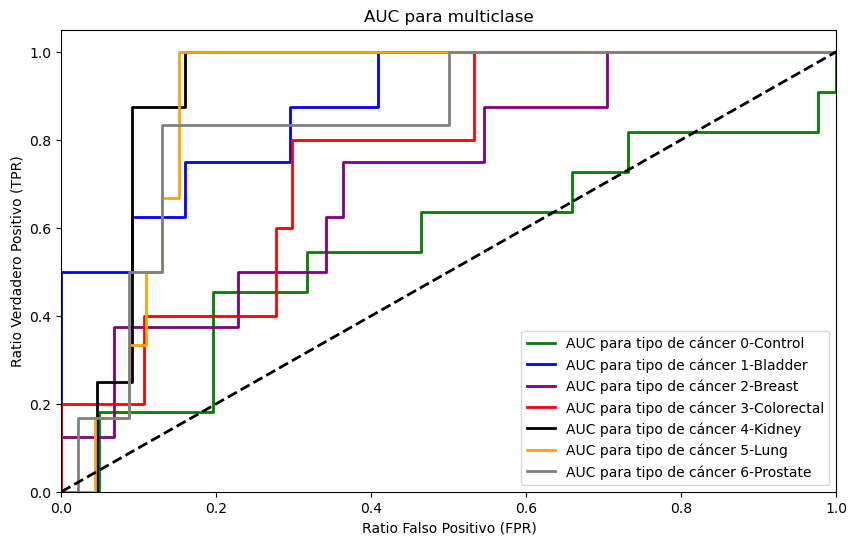

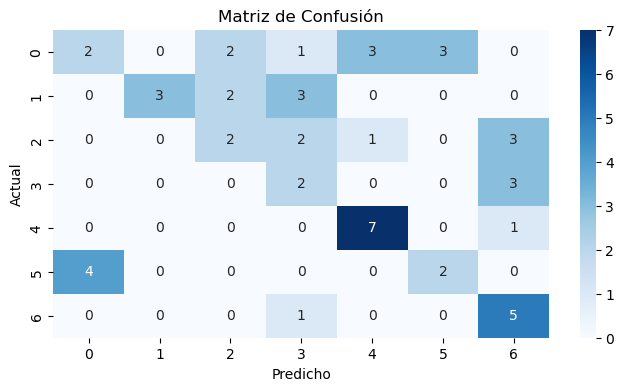



Puntuación Jaccard para el cáncer tipo 0-Control.... 0.1333
Puntuación Jaccard para el cáncer tipo 1-Bladder.... 0.3750
Puntuación Jaccard para el cáncer tipo 2-Breast..... 0.1667
Puntuación Jaccard para el cáncer tipo 3-Colorectal. 0.1667
Puntuación Jaccard para el cáncer tipo 4-Kidney..... 0.5833
Puntuación Jaccard para el cáncer tipo 5-Lung....... 0.2222
Puntuación Jaccard para el cáncer tipo 6-Prostate... 0.3846

Media de la puntuación de Jaccard: 0.2903


In [10]:
if M_TIPO.startswith("bin"):
    myfunc.ver_metricas(mejor_modelo, X_test, y_test)
else:
    myfunc.ver_metricas_multi(mejor_modelo, X_test, y_test)


#### Finalización del notebook

In [11]:
end_time = datetime.datetime.now()
total_time = end_time - start_time
myfunc.verbose(f"Notebook ha tardado {total_time.seconds} seconds")

20231030T190755 : amilcar22 : INFO : Notebook ha tardado 767 seconds


#### Guardar métricas

In [12]:
if M_TIPO.startswith("bin"):
    myfunc.save_metricas_to_csv(random_search, X_test, y_test, M_TIPO, M_SELECT, M_CLASIF, total_time, SEMILLA, myfunc.MET_DIR, M_FICHERO, fichero_modelo)
else:
    myfunc.save_metricas_multi_to_csv(random_search, X_test, y_test, M_TIPO, M_SELECT, M_CLASIF, total_time, SEMILLA, myfunc.MET_DIR, M_FICHERO, fichero_modelo)

df1=myfunc.read_metricas_to_df(myfunc.MET_DIR,M_FICHERO)

display(df1.sort_values("datetime", ascending=False)[:3])


20231030T190755 : amilcar22 : INFO : Inicio guardar métricas multiclase
20231030T190755 : amilcar22 : INFO : Inicio leer fichero ../tfm_git/ejecuciones/metricas/metricas_6390.csv
20231030T190755 : amilcar22 : INFO : Fin leer fichero ../tfm_git/ejecuciones/metricas/metricas_6390.csv
20231030T190755 : amilcar22 : INFO : Inicio guardar fichero ../tfm_git/ejecuciones/metricas/metricas_6390.csv
20231030T190755 : amilcar22 : INFO : Fichero borrado ../tfm_git/ejecuciones/metricas/metricas_6390.csv


20231030T190755 : amilcar22 : INFO : Fin guardar fichero ../tfm_git/ejecuciones/metricas/metricas_6390.csv
20231030T190755 : amilcar22 : INFO : Fin guardar métricas multiclase
20231030T190755 : amilcar22 : INFO : Inicio leer fichero ../tfm_git/ejecuciones/metricas/metricas_6390.csv
20231030T190755 : amilcar22 : INFO : Fin leer fichero ../tfm_git/ejecuciones/metricas/metricas_6390.csv


,tipo,select,clasific,semilla,accuracy,precision,recall,f1_score,roc_auc,hostname,total_time_sec,datetime,fichero_modelo,params,shape,features,roc_auc_ovr,indices_auc,indices_jaccard
0,mul_s,MI,LR_L1,6390,0.442308,0.477417,0.464069,0.429744,NaN,amilcar22,767,2023-10-30 19:07:55.361761,modelo_6390_mul_s_MI_LR_L1.pkl,"{'selector__k': 500, 'clasifier__solver': 'sag...","X_test:(52, 18875)","['ENSG00000003137.9', 'ENSG00000005513.10', 'E...",0.792789,"[0.5609756097560976, 0.8806818181818181, 0.710...","[0.13333333333333333, 0.375, 0.166666666666666..."
0,mul_s,MI,LR_EN,6390,0.500000,0.546279,0.507900,0.485621,NaN,amilcar22,1382,2023-10-30 18:55:01.797152,modelo_6390_mul_s_MI_LR_EN.pkl,"{'selector__k': 1000, 'clasifier__solver': 'sa...","X_test:(52, 18875)","['ENSG00000003137.9', 'ENSG00000004864.14', 'E...",0.836884,"[0.6452328159645233, 0.9289772727272727, 0.761...","[0.2857142857142857, 0.375, 0.1818181818181818..."
0,mul_s,ANOVA,SVM,6390,0.365385,0.363152,0.374892,0.331833,NaN,amilcar22,2,2023-10-30 18:31:53.208116,modelo_6390_mul_s_ANOVA_SVM.pkl,"{'selector__k': 200, 'clasifier__kernel': 'rbf...","X_test:(52, 18875)","['ENSG00000000938.13', 'ENSG00000005381.9', 'E...",0.762860,"[0.458980044345898, 0.8210227272727272, 0.6619...","[0.08333333333333333, 0.5, 0.0, 0.071428571428..."


#### Guardar resultados

In [13]:
fichero_resultados=R_FICHERO+"_"+M_TIPO+"-"+M_SELECT+"-"+M_CLASIF+".csv"
myfunc.save_resultados_to_csv(M_TIPO, M_SELECT, M_CLASIF,  random_search, myfunc.MET_DIR, fichero_resultados)


20231030T190755 : amilcar22 : INFO : Inicio guardar resultados
20231030T190755 : amilcar22 : INFO : Inicio guardar fichero ../tfm_git/ejecuciones/metricas/resultados_6390_mul_s-MI-LR_L1.csv
20231030T190755 : amilcar22 : INFO : Fin guardar fichero ../tfm_git/ejecuciones/metricas/resultados_6390_mul_s-MI-LR_L1.csv
20231030T190755 : amilcar22 : INFO : Fin guardar resultados
